# Experiment 1

## Goal
* Demonstrate an example of calling the ChatGPT API and format output
* Use ChatGPT to generate some clinical notes to accompany synthetic A&E data

## Dataset 

NHS England prepared a synthetic dataset of A&E presentations. 

A blog post about it is here https://open-innovations.org/blog/2019-01-24-exploring-methods-for-creating-synthetic-a-e-data. 

The dataset can be accessed from this website https://data.england.nhs.uk/dataset/a-e-synthetic-data/resource/81b068e5-6501-4840-a880-a8e7aa56890e#

Unfortunately, there is no data dictionary. Therefore, here I only use data which can be intuively understood ie:  

* Age_Band
* AE_Arrive_HourOfDay
* AE_Time_Mins
* Admitted_Flag - assuming 1 means yes
* ICD10_Chapter_Code - for more see https://en.wikipedia.org/wiki/ICD-10
* Length_Of_Stay_Days


## Set up

In [2]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [49]:
# Load libraries
import sys
import os
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Import the variables that have been set in the init.py folder in the root directory
# These include a constant called PROJECT_ROOT which stores the absolute path to this folder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import init
PROJECT_ROOT = os.getenv("PROJECT_ROOT")

# Add the src folder to sys path, so that the application knows to look there for libraries
sys.path.append(str(Path(PROJECT_ROOT) / 'src'))

# Import function to load data
from data_ingestion.load_data import load_file



## Load data

Here load_file()  

* check if the NHS England datset has already been saved in a local folder called data_store in a parquet format; is so return it
* if not, it checks for the zip file from the NHSE website and if not downloads it, unzips it and saves it 
* the file is unzipped to csv and read as as pandas dataframe and saved to parquet format

In [50]:
ed = load_file()
# ed.head()

In [6]:
print(min(ed.AE_Arrive_Date))
print(max(ed.AE_Arrive_Date))

2014-03-23 00:00:00
2018-03-22 00:00:00


As noted above, we will only use the following columns initially:

In [4]:
# ed[['Age_Band', 'AE_Arrive_HourOfDay', 'AE_Time_Mins', 'Admitted_Flag', 'Length_Of_Stay_Days', 'ICD10_Chapter_Code', 'Title']].head()

## Explore the dataset

Among the variables with interpretable names, the following plots show their distributions

### Age band

Histogram shows a weighting towards older patients, following the typical distribution of A&E patients in the UK

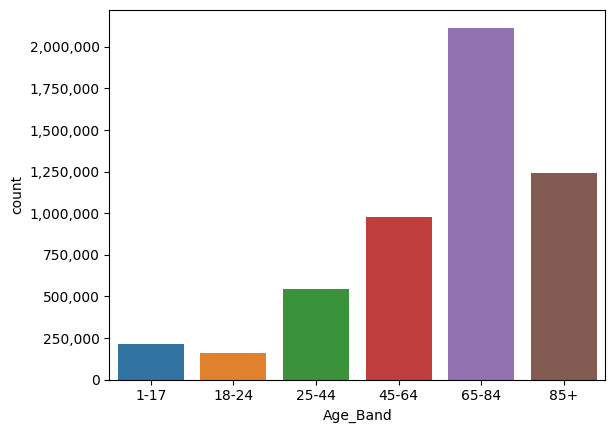

In [54]:
from matplotlib.ticker import FuncFormatter

# Set 'Age_Band' as ordered categorical data
ed['Age_Band'] = pd.Categorical(ed['Age_Band'], categories=['1-17', '18-24', '25-44', '45-64', '65-84', '85+'], ordered=True)

# Plot count of each age band
sns.countplot(x='Age_Band', data=ed, order=['1-17', '18-24', '25-44', '45-64', '65-84', '85+'])

# Format y-axis labels as plain numbers
plt.ticklabel_format(style='plain', axis='y')

# Add comma separator for y-axis labels
ax = plt.gca()
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))


### Time in A&E

The A&E targets to admit people within four hours are very apparent from the distribution of the variable showing time spent in A&E. These data were collected between 2014 and 2018 in the UK. Since then, the four hour targets are more often missed  

<Axes: xlabel='AE_Time_Mins', ylabel='Count'>

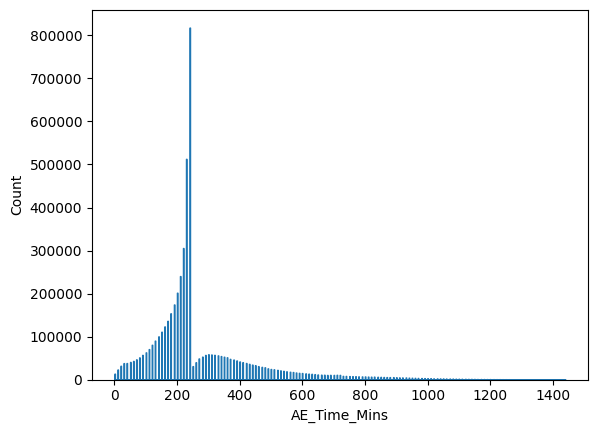

In [58]:
sns.histplot(ed['AE_Time_Mins'], element='step')


### Hour of arrival at A&E

Arrivals are at the their maximum in the morning and early afternoon. 

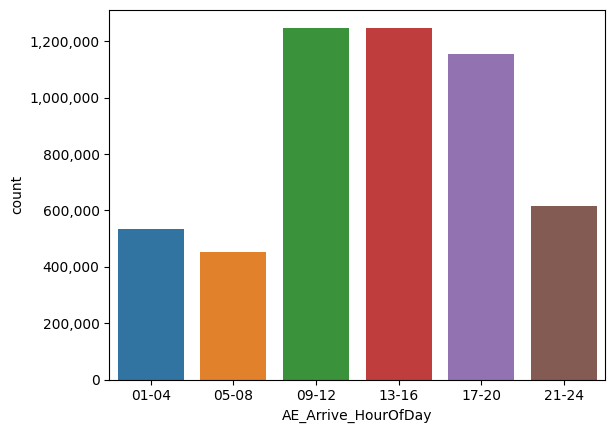

In [65]:
categories_order = ['01-04', '05-08', '09-12', '13-16', '17-20', '21-24']
ed['AE_Arrive_HourOfDay'] = pd.Categorical(ed['AE_Arrive_HourOfDay'], categories=categories_order, ordered=True)
sns.countplot(x='AE_Arrive_HourOfDay', data=ed, order=categories_order)

# Format y-axis labels as plain numbers
plt.ticklabel_format(style='plain', axis='y')

# Add comma separator for y-axis labels
ax = plt.gca()
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))


### Length of stay in hospital

There are some very long staying patients, as the left hand boxplot shows. The right hand plot filter to include only visits of less than 25 days. Among these, the median length of stay is 5 days. 

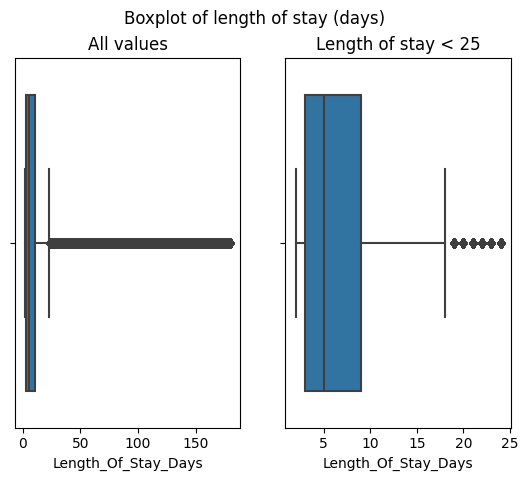

In [75]:
import matplotlib.pyplot as plt

# Create two subplots
fig, axes = plt.subplots(1, 2)

# Left plot: All values
sns.boxplot(x='Length_Of_Stay_Days', data=ed, ax=axes[0])
axes[0].set_title('All values')

# Right plot: Length_Of_Stay_Days < 25
sns.boxplot(x='Length_Of_Stay_Days', data=ed[ed['Length_Of_Stay_Days'] < 25], ax=axes[1])
axes[1].set_title('Length of stay < 25')

fig.suptitle('Boxplot of length of stay (days)')

plt.show()


### Presenting condition

Each patient has a ICD10 code. Here they are shown with the associated title from https://en.wikipedia.org/wiki/ICD-10. The majority are respiratory conditions. 

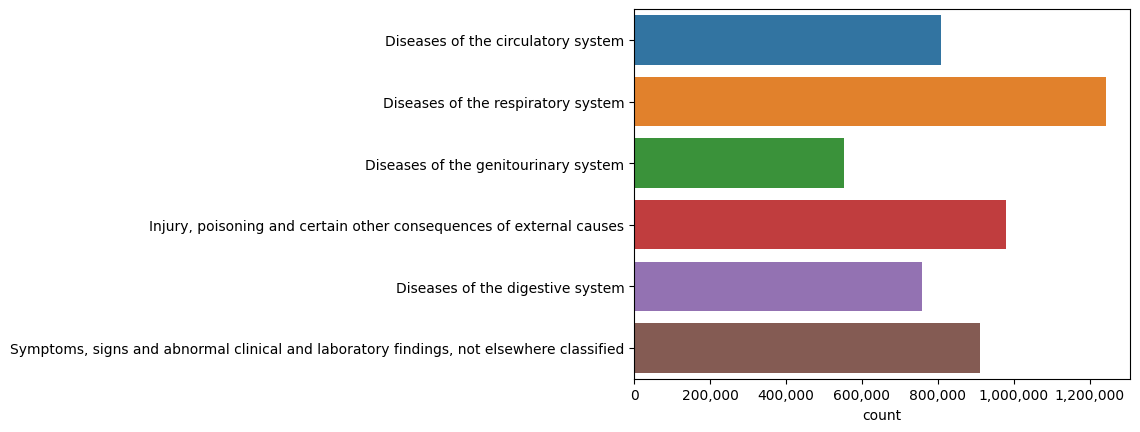

In [80]:
sns.countplot(y='Title', data=ed)
plt.ylabel('')

plt.ticklabel_format(style='plain', axis='x')
ax = plt.gca()
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show();




## Generate an instance of a patient using the dataset

This calls a class definition called Patient. An instance of this class, here referred to as a persona, is a single Patient. The instance is populated with all the variables retrieved from the ED dataset above.

In addition, a first call to ChatGPT is made using the OpenAI API. The information listed below is embedded into the prompt to be passed in. ChatGPT is asked to generate a medical condition, given the characteristics below. For more details, see the class definition in functions.patient_class.py

In [43]:
ed[['Age_Band', 'AE_Arrive_HourOfDay', 'AE_Time_Mins',  'Length_Of_Stay_Days', 'ICD10_Chapter_Code', 'Title']].iloc[10000]

Age_Band                                            65-84
AE_Arrive_HourOfDay                                 09-12
AE_Time_Mins                                          370
Length_Of_Stay_Days                                  12.0
ICD10_Chapter_Code                                     IX
Title                  Diseases of the circulatory system
Name: 10000, dtype: object

In [56]:
from functions.patient_class import Patient

def row_to_patient(row):
    return Patient(*row)

In [87]:
persona = ed[ed.Title == "Diseases of the circulatory system"].iloc[10000]
Pat = row_to_patient(persona)

The medical condition has been generated by ChatGPT based on the prompt inputted. 

In [88]:
Pat.Medical_Condition


'failed on json argument'

Unfortunately, in this instance, the admission note was not generated. 

In [89]:
Pat.Admission_Note

'failed on json argument'